# first test model

We try here to clasify the waves to language

In [1]:
import torch
import polars as pl
import numpy as np
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dfTrain = pl.read_csv("../data/train_clean.csv").sample(fraction=1.0, shuffle=True)
dfTrain.head()

shape: (5, 4)
┌───────────┬─────────────────────────────────┬──────────────────┬───────┐
│ client_id ┆ path                            ┆ language         ┆ label │
│ ---       ┆ ---                             ┆ ---              ┆ ---   │
│ i64       ┆ str                             ┆ str              ┆ i64   │
╞═══════════╪═════════════════════════════════╪══════════════════╪═══════╡
│ 1807      ┆ /Slovenian/train/slv_trn_sp_1/… ┆ Slovenian        ┆ 5     │
│ 407       ┆ /Romanian/train/rmn_trn_sp_39/… ┆ Romanian         ┆ 29    │
│ 42        ┆ /Chinese_Taiwan/train/chtw_trn… ┆ Chinese_Taiwan   ┆ 24    │
│ 218       ┆ /Kyrgyz/train/kyr_trn_sp_59/co… ┆ Kyrgyz           ┆ 16    │
│ 455       ┆ /Chinese_Hongkong/train/chkg_t… ┆ Chinese_Hongkong ┆ 25    │
└───────────┴─────────────────────────────────┴──────────────────┴───────┘

In [3]:
import torch
from torch.utils.data import Dataset
import torchaudio as ta
import torchaudio.transforms as T

SAMPLE_RATE = 16000
MEL_TRANSFORM = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

class VoiceDataset(Dataset):
    def __init__(self, df:pl.DataFrame, transform=MEL_TRANSFORM, target_sr=SAMPLE_RATE, root="."):
        self.paths = df['path']
        self.labels = df['label']
        self.transform = transform
        self.target_sr = target_sr
        self.root = root

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.root + self.paths[index]

        waveform, sample_rate = ta.load(path)
        
        if sample_rate != self.target_sr:
            waveform = ta.functional.resample(waveform,sample_rate, self.target_sr)

        if self.transform is not None:
            features = self.transform(waveform)
            features = torch.cat([features, features], dim=2)
        else:
            features = waveform

        label = self.labels[index]

        return features, label

In [4]:
from torch.utils.data import DataLoader

dataset = VoiceDataset(dfTrain, root="../data/common_voice_kpd")

def pad_collate(batch):
    features = [item[0].squeeze(0).transpose(0,1) for item in batch]  # (n_mels, T) → (T, n_mels) pour LSTM
    labels = [item[1] for item in batch]

    lengths = torch.tensor([f.shape[0] for f in features])

    padded = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)

    return padded, torch.tensor(labels), lengths

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=pad_collate
)

In [32]:
len(dfTrain)

22194

In [36]:
min = len(dataset[0][0][0][0])
for i in range(22194):
    if len(dataset[i][0][0][0]) <min:
        min = len(dataset[i][0][0][0])

print(min)

56


In [ ]:
dataset[0][0].shape

torch.Size([1, 64, 460])

In [39]:
50*65

3250

## Dataset

this class take the raw audio and resample it to fit the SAMPLE_RATE needed. Insted of VoiceDataset, who transforme the audio into a spectograme.The goal here is to have raw audio to apply wav2vec2.

In [5]:
import IPython
import torch
from torch.utils.data import Dataset
import torchaudio

SAMPLE_RATE = 16000

class AudioDataset(Dataset):
    def __init__(self, df, root=""):
        self.paths = df["path"]
        self.labels = df["label"]
        self.root = root

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.root + self.paths[idx])

        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(
                waveform, sr, SAMPLE_RATE
            )
        #waveform = waveform.squeeze(0)  # [T]
        label = self.labels[idx]

        return waveform, label

dataset = AudioDataset(dfTrain, root="../data/common_voice_kpd")

In [6]:
dataset[2003][0].shape

torch.Size([1, 39552])

In [7]:
IPython.display.Audio("../data/common_voice_kpd/Arabic/train/ara_trn_sp_142/common_voice_ar_19204410.wav")

In [39]:
BUNDLE = torchaudio.pipelines.WAV2VEC2_XLSR_300M
BUNDLE.sample_rate

16000

In [40]:
WAV2VEC2_MODEL = BUNDLE.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_xlsr_300m.pth" to /home/ilian/.cache/torch/hub/checkpoints/wav2vec2_xlsr_300m.pth


100%|██████████| 1.18G/1.18G [00:46<00:00, 27.0MB/s]


In [64]:
data = dataset[2080][0][0,0:16000*3].reshape(1, -1)
with torch.inference_mode():
    features, _ = WAV2VEC2_MODEL.extract_features(data)

features[1].shape, len(features)

(torch.Size([1, 149, 1024]), 24)

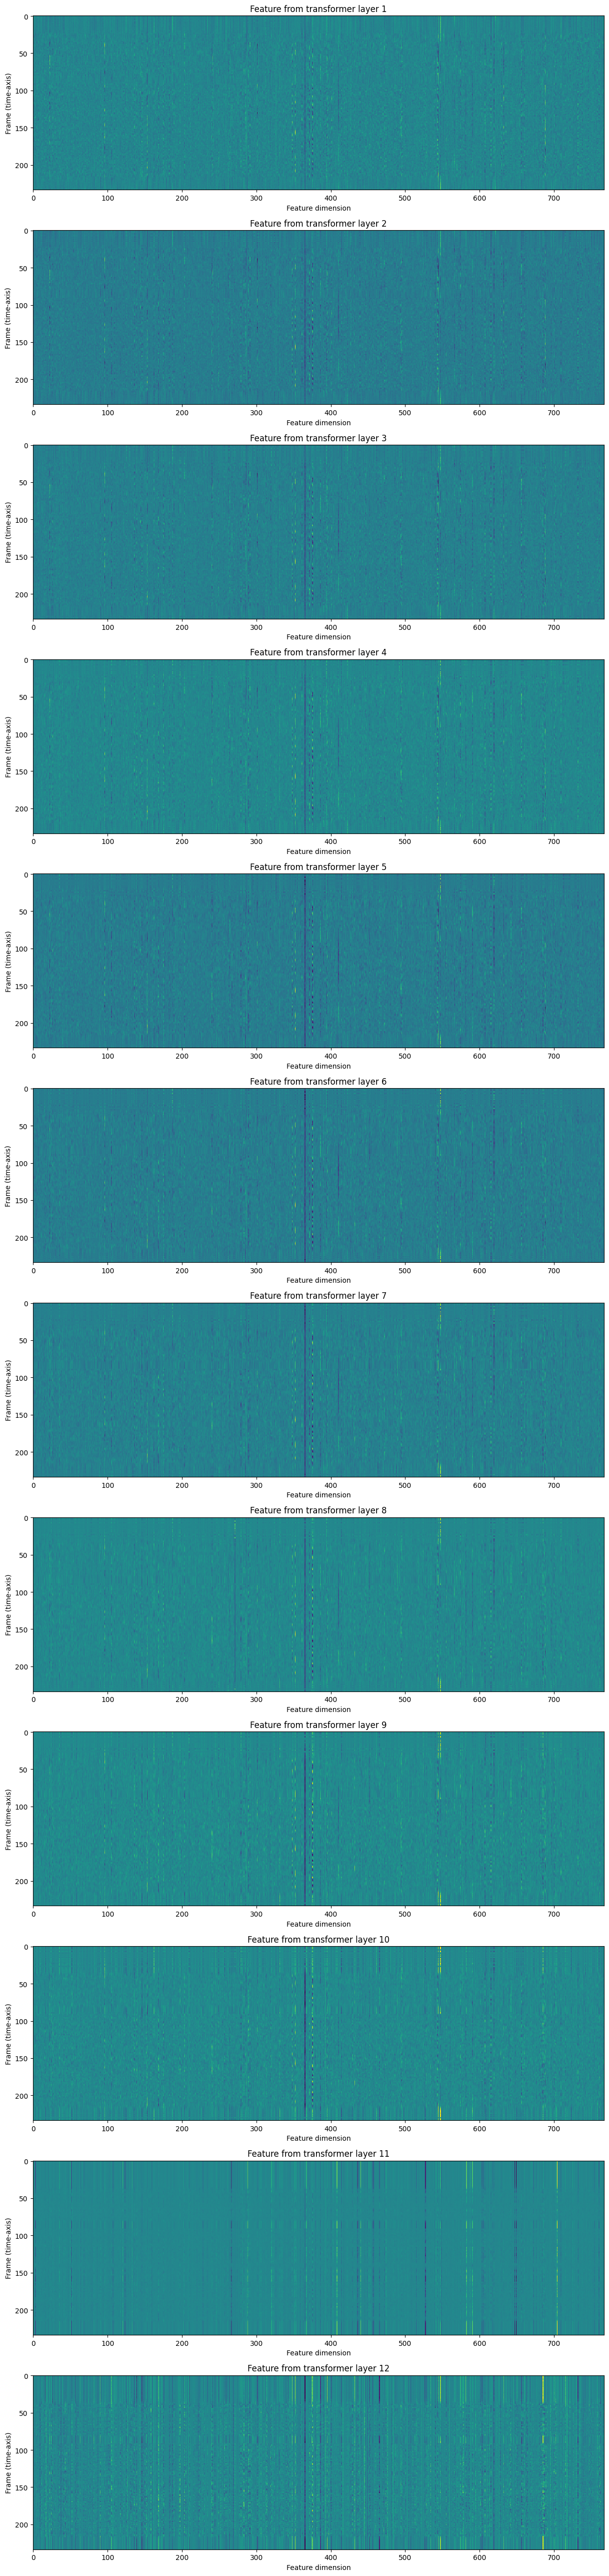

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [25]:
with torch.inference_mode():
    emission, _ = WAV2VEC2_MODEL(dataset[778][0])

emission.shape

torch.Size([1, 518, 29])

## Convolution Neural Network

we have translate audio into 24 images of (149,1024) pixel. Now we try to classify the data

In [ ]:
import torch.nn as nn

CONV_LAYERS = [
    [1, 4, 3, 1, 1],
    [4, 8, 3, 1, 1],
    [8, 16, 3, 1, 1]
]

class LargeLanguageMappingModel(nn.Module):
    def __init__(self, conv_layers=CONV_LAYERS, input_dim=(24,149,1024)):
        super(LargeLanguageMappingModel, self).__init__()
        
        self.conv_layers = cnn = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 4)),  # -> (32, 12, 74, 256)

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 4)),  # -> (64, 6, 37, 64)

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),  # -> (128, 3, 18, 32)

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # -> (256, 1, 1, 1)
        )
        self.fc = nn.Linear(256, 45)

    def forward(self, x):
        x = x.unsqueeze(1)  # Ajouter une dimension de canal
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = LargeLanguageMappingModel()
model


LargeLanguageMappingModel(
  (conv1): Conv3d(1, 8, kernel_size=(2, 3, 3), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(8, 16, kernel_size=(2, 3, 3), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(16, 32, kernel_size=(2, 3, 3), stride=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=123904, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=45, bias=True)
)

In [70]:
1020/4

255.0